# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [8]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

100%|██████████| 135107811/135107811 [01:12<00:00, 1865987.28it/s]


In [9]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [21]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Split train database into Train & Validation for part testing your model

(Review Project)Your test_loader is exposed to the training model, this could have contribute to the model performing well on the test data because it has memorized the test data during training. The test data is meant to be set aside during training for the purpose to be used to checki the accuracy of the model's performance after training (but in your case, it was used in during training to validate the model, I'd recommend you create a validation dataset out of the training data for the purpose of model evaluation).

After you have created a validation dataset, only use that in the training loop to validate the model. Next use the test_loader to measure models performance on unseen data. This help to detect the actual performance of the model.

In [23]:
import os
import numpy as np
import shutil
import random
root_dir = './data/cifar10/train/' # data root path
classes_dir = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] #total labels

val_ratio = 0.20

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'val/' + cls)

# Creating partitions of the data after shuffeling
src = root_dir + cls # Folder to copy images from

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                          [int(len(allFileNames)* (1 - val_ratio))])

[int(len(allFileNames)* (1 - (val_ratio + test_ratio))),  int(len(allFileNames)* (1 - test_ratio))])

train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))

# Copy-pasting images
for cls in classes_dir:
       # Copy-pasting images
    for name in train_FileNames:
            shutil.copy(name, root_dir +'train/' + cls)

    for name in val_FileNames:
            shutil.copy(name, root_dir +'val/' + cls)


Total images:  5000
Training:  4000
Validation:  1000


In [34]:
np.array(allFileNames)

array(['2200.png', '2750.png', '4269.png', ..., '3808.png', '4015.png',
       '4852.png'], dtype='<U8')

In [35]:
[int(len(allFileNames)* (1 - val_ratio))]

[4000]

In [75]:
# Define transforms
## YOUR CODE HERE ##
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# Create training set and define training dataloader

## YOUR CODE HERE ##
train_data = ImageFolder( data_dir+'/train', transform =  transform_train)
train_loader = torch.utils.data.DataLoader(train_data,batch_size = 250 ,shuffle = True)

#I'd recommend you create a validation dataset out of the training data for the purpose of model evaluation
transform_validation = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

validation_data = ImageFolder( data_dir+'/val', transform =  transform_validation)
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size = 250 ,shuffle = True)



# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [80]:
# Create test set and define test dataloader

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
## YOUR CODE HERE ##
test_data = ImageFolder( data_dir+'/test', transform = transform_test)
test_loader=torch.utils.data.DataLoader(test_data,batch_size = 250 ,shuffle = True)

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [66]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        std = (.5, .5, .5)
        mean = (.5, .5, .5)
        for i in range(3):
            image[i] = std[i] * image[i] + mean[i]
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

frog


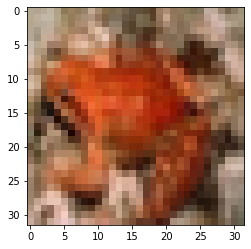

ship


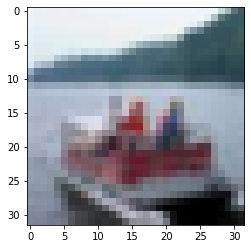

truck


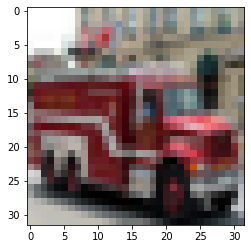

truck


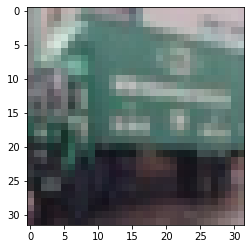

truck


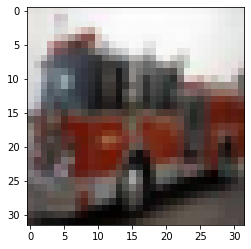

In [67]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)

frog


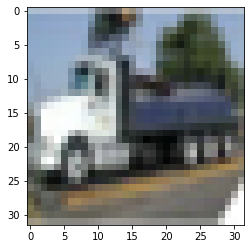

frog


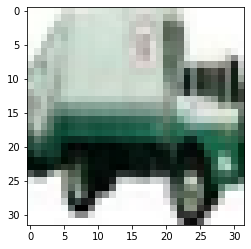

deer


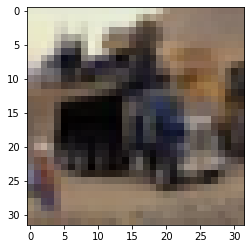

truck


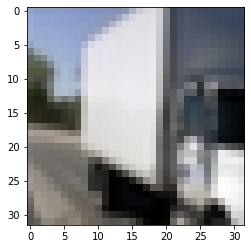

horse


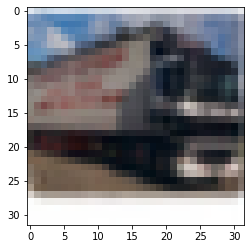

In [68]:
# Explore data
## YOUR CODE HERE ##
show5(validation_loader)

In [69]:
images, labels = next(iter(train_loader))
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([250, 3, 32, 32])
torch.Size([250])


In [71]:
images, labels = next(iter(validation_loader))
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([1000, 3, 32, 32])
torch.Size([1000])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [72]:
## YOUR CODE HERE ##
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
    param.requires_grad = False
    
# TODO: Define your network architecture here

model = nn.Sequential(nn.Linear(3072, 256),
                      nn.ReLU(),
                      nn.Linear(256, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

model.to(device)

Sequential(
  (0): Linear(in_features=3072, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [73]:
## YOUR CODE HERE ##

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr=0.002)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [77]:
## YOUR CODE HERE ##
epochs = 10
train_losses, validation_losses = [], []

for e in range(epochs):
    running_loss = 0
    loss_values = []

    for images, labels in train_loader:
        # Flatten  images into a 1D long vector
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        validation_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in validation_loader:
                images = images.view(images.shape[0], -1)
                output = model.forward(images)
                validation_loss += criterion(output, labels)
                
                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()       
        train_losses.append(running_loss/len(train_loader))
        validation_losses.append(validation_loss/len(validation_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "validation Loss: {:.3f}.. ".format(validation_loss/len(validation_loader)),
              "validation Accuracy: {:.3f}".format(accuracy/len(validation_loader)))

Epoch: 1/10..  Training Loss: 1.662..  test Loss: 1.515..  test Accuracy: 0.467
Epoch: 2/10..  Training Loss: 1.465..  test Loss: 1.430..  test Accuracy: 0.499
Epoch: 3/10..  Training Loss: 1.386..  test Loss: 1.406..  test Accuracy: 0.500
Epoch: 4/10..  Training Loss: 1.324..  test Loss: 1.400..  test Accuracy: 0.513
Epoch: 5/10..  Training Loss: 1.287..  test Loss: 1.334..  test Accuracy: 0.532
Epoch: 6/10..  Training Loss: 1.244..  test Loss: 1.345..  test Accuracy: 0.527
Epoch: 7/10..  Training Loss: 1.207..  test Loss: 1.342..  test Accuracy: 0.529
Epoch: 8/10..  Training Loss: 1.175..  test Loss: 1.327..  test Accuracy: 0.536
Epoch: 9/10..  Training Loss: 1.147..  test Loss: 1.337..  test Accuracy: 0.538
Epoch: 10/10..  Training Loss: 1.126..  test Loss: 1.321..  test Accuracy: 0.547


Plot the training loss (and validation loss/accuracy, if recorded).

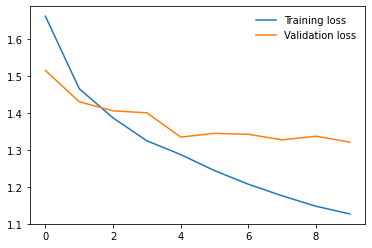

In [78]:
## YOUR CODE HERE ##

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

In [79]:
test_loss = 0
accuracy = 0

# Turn off gradients for test, saves memory and computations
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images = images.view(images.shape[0], -1)
        output = model.forward(images)
        test_loss += criterion(output, labels)

        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
model.train()       
test_losses.append(test_loss/len(test_loader))

print("Epoch: {}/{}.. ".format(e+1, epochs),
      "test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
      "test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 10/10..  validation Loss: 5.038..  validation Accuracy: 0.100


## Build and run with transfer learning

In [17]:
from torchvision import models

In [84]:
train_losses, validation_losses = [], []
model = models.vgg16(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(25088, 256),
                             nn.ReLU(),
                             nn.Dropout(0.3),
                             nn.Linear(256, 10),
                             nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

epochs = 1
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    running_loss = 0
    
    for inputs, labels in train_loader:
        steps += 1

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    valid_loss += batch_loss.item()

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            model.train()
            train_losses.append(running_loss/len(train_loader))
            validation_losses.append(valid_loss/len(validation_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {valid_loss/len(validation_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validation_loader):.3f}")                      

Epoch 1/1.. Train loss: 5.882.. Test loss: 3.255.. Test accuracy: 0.443
Epoch 1/1.. Train loss: 8.755.. Test loss: 1.679.. Test accuracy: 0.501
Epoch 1/1.. Train loss: 10.484.. Test loss: 1.614.. Test accuracy: 0.466
Epoch 1/1.. Train loss: 12.221.. Test loss: 1.489.. Test accuracy: 0.501
Epoch 1/1.. Train loss: 13.716.. Test loss: 1.403.. Test accuracy: 0.525
Epoch 1/1.. Train loss: 15.225.. Test loss: 1.347.. Test accuracy: 0.551
Epoch 1/1.. Train loss: 16.707.. Test loss: 1.290.. Test accuracy: 0.562
Epoch 1/1.. Train loss: 18.075.. Test loss: 1.262.. Test accuracy: 0.571
Epoch 1/1.. Train loss: 19.456.. Test loss: 1.261.. Test accuracy: 0.569
Epoch 1/1.. Train loss: 20.797.. Test loss: 1.224.. Test accuracy: 0.579
Epoch 1/1.. Train loss: 22.139.. Test loss: 1.204.. Test accuracy: 0.589
Epoch 1/1.. Train loss: 23.473.. Test loss: 1.205.. Test accuracy: 0.589
Epoch 1/1.. Train loss: 24.816.. Test loss: 1.203.. Test accuracy: 0.593
Epoch 1/1.. Train loss: 26.102.. Test loss: 1.181.. T

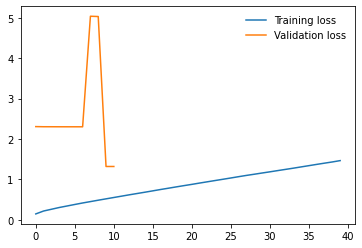

In [86]:
## YOUR CODE HERE ##

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)        

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [70]:
images, labels = next(iter(test_loader))
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([250, 3, 32, 32])
torch.Size([250])


In [83]:
##YOUR CODE HERE##

test_loss = 0
accuracy = 0

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images = images.view(images.shape[0], -1)
        output = model.forward(images)
        validation_loss += criterion(output, labels)

        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
model.train()       
validation_losses.append(test_loss/len(test_loader))

print("Accuracy of the network on the validation set: {:.3f}".format(accuracy/len(test_loader)))

Accuracy of the network on the validation set: 0.547


## Saving your model
Using `torch.save`, save your model for future loading.

In [110]:
## YOUR CODE HERE ##
print("Final model: \n\n", model, '\n')

##Save Model  torch.save(model.state_dict(), PATH)
print("Model state dict keys: \n\n", model.state_dict().keys())
torch.save(model.state_dict(), 'checkpoint.pth')

Final model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddi

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

As we can see on the previous steps we have 2 scenarios. The first one is a neural network trained by me who have 54.5% of accuracy, according to the requirements is a decent perfomance but not enough, the second scenario is using Transfer Learning wich accuracy increase to 62%. In the last 2 scenarios we didnt reach the goal of have 70% or more in accuracy. 

For this reason the recomendation is buy Detectocorp model for a short-term because with more time and study im sure that as data scienctist i can exceed the accuracy goal using more existing architectures or preloaded models from torchvision.